# Information theory: the noisy binary symmetric channel

Florent Leclercq,<br/>
Institute of Cosmology and Gravitation, University of Portsmouth,<br/>
florent.leclercq@polytechnique.org

In [1]:
import numpy as np
from scipy.special import binom
from matplotlib import pyplot as plt
%matplotlib inline

## The signal

In [2]:
from PIL import Image
im_data = Image.open('data/correlation.png')
im_grey = im_data.convert('L')
signal = np.array(im_grey, dtype=np.int)
signal[np.where(signal>1)]=1

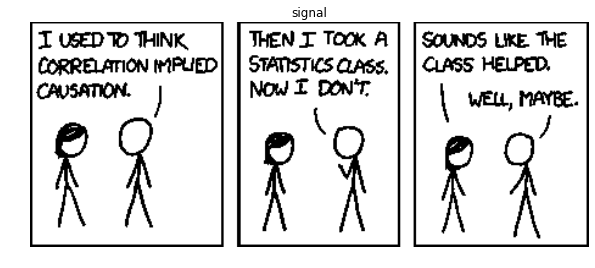

In [3]:
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(signal,cmap="Greys_r",interpolation=None)
plt.title("signal")
plt.show() 

## The noisy binary symmetric channel

In [4]:
def noisy_channel(transmitted,noise_level):
    received=np.copy(transmitted)
    noise=np.random.uniform(size=received.shape)
    received[np.where(noise<noise_level)]+=1
    return np.mod(received,2)

In [5]:
noise_level=0.1

In [6]:
sent=np.array((1,0,1,1,1,0,1,0,1,1))
received=noisy_channel(sent,noise_level)
print "sent :\t\t"+str(sent)
print "received :\t"+str(received)

sent :		[1 0 1 1 1 0 1 0 1 1]
received :	[0 0 1 1 1 0 1 0 1 1]


In [7]:
noisy_signal=noisy_channel(signal,noise_level)

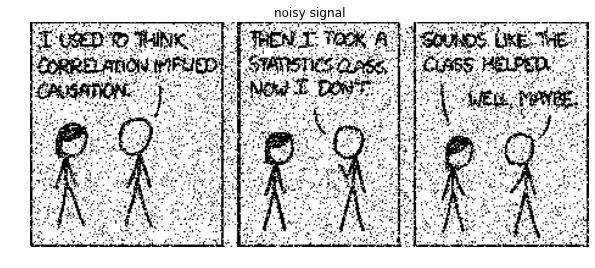

In [8]:
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(noisy_signal,cmap="Greys_r",interpolation=None)
plt.title("noisy signal")
plt.show() 

## The R3 code

In [9]:
def R3_encoder(signal):
    m1=np.copy(signal)
    m2=np.copy(signal)
    m3=np.copy(signal)
    return np.array((m1,m2,m3))

In [10]:
def R3_decoder(received):
    decoded=np.zeros_like(received[0])
    decoded[np.where(received[0]+received[1]+received[2]>=2)]=1
    return decoded

In [11]:
transmitted=R3_encoder(signal)
received=noisy_channel(transmitted,noise_level)
decoded=R3_decoder(received)

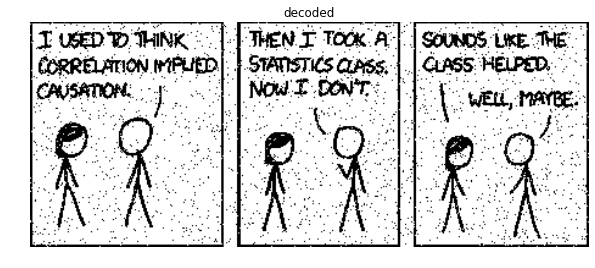

In [12]:
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(decoded,cmap="Greys_r",interpolation=None)
plt.title("decoded")
plt.show()

## The (7,4) Hamming code

In [16]:
Hamming_matrix=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[1,1,1,0],[0,1,1,1],[1,0,1,1]])
syndrome_matrix=np.array([[1,1,1,0,1,0,0],[0,1,1,1,0,1,0],[1,0,1,1,0,0,1]])

def split_signal_4bits_blocks(signal):
    split=signal.reshape(signal.shape[0]*signal.shape[1])
    N_dummy_bits=-len(split)%4
    split=np.concatenate((split,np.zeros(N_dummy_bits)))
    return np.split(split,len(split)/4)

def Hamming_encoder(signal):
    split_signal=split_signal_4bits_blocks(signal)
    transmitted=np.zeros((len(split_signal),7),dtype=np.int)
    for i in xrange(len(split_signal)):
        signal_block=split_signal[i]
        transmitted_block=Hamming_matrix.dot(signal_block)
        transmitted[i]=transmitted_block
    return np.mod(transmitted,2)

def compute_syndrom(received_block):
    return np.mod(syndrome_matrix.dot(received_block),2)

def correct_block(received_block):
    syndrom=compute_syndrom(received_block)
    corrected_block=np.copy(received_block)
    if np.array_equal(syndrom,np.array((0,0,1))):
        corrected_block[6]+=1
    elif np.array_equal(syndrom,np.array((0,1,0))):
        corrected_block[5]+=1
    elif np.array_equal(syndrom,np.array((0,1,1))):
        corrected_block[3]+=1
    elif np.array_equal(syndrom,np.array((1,0,0))):
        corrected_block[4]+=1
    elif np.array_equal(syndrom,np.array((1,0,1))):
        corrected_block[0]+=1
    elif np.array_equal(syndrom,np.array((1,1,0))):
        corrected_block[1]+=1
    elif np.array_equal(syndrom,np.array((1,1,1))):
        corrected_block[2]+=1
    return np.mod(corrected_block,2)

def reshape_corrected_7bits_blocks(corrected,signal_shape):
    decoded=np.zeros((corrected.shape[0],4))
    for i in xrange(corrected.shape[0]):
        corrected_block=corrected[i]
        decoded[i]=np.array((corrected_block[0],corrected_block[1],corrected_block[2],corrected_block[3])
                            ,dtype=np.int)
    decoded=decoded.flatten()
    signal_length=signal_shape[0]*signal_shape[1]
    N_dummy_bits=-signal_length%4
    decoded=decoded[:-N_dummy_bits]
    decoded=decoded.reshape(signal_shape[0],signal_shape[1])    
    return decoded
    
def Hamming_decoder(received,signal_shape):
    corrected=np.copy(received)
    for i in xrange(received.shape[0]):
        received_block=received[i]
        corrected_block=correct_block(received_block)
        corrected[i]=corrected_block
    return reshape_corrected_7bits_blocks(corrected,signal_shape)

In [17]:
transmitted=Hamming_encoder(signal)
received=noisy_channel(transmitted,noise_level)
decoded=Hamming_decoder(received,signal.shape)
received_im=reshape_corrected_7bits_blocks(received,signal.shape)

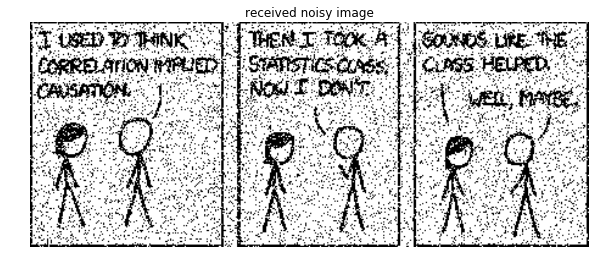

In [18]:
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(received_im,cmap="Greys_r",interpolation=None)
plt.title("received noisy image")
plt.show()

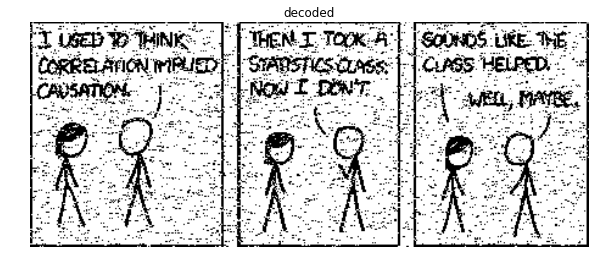

In [19]:
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(decoded,cmap="Greys_r",interpolation=None)
plt.title("decoded")
plt.show() 

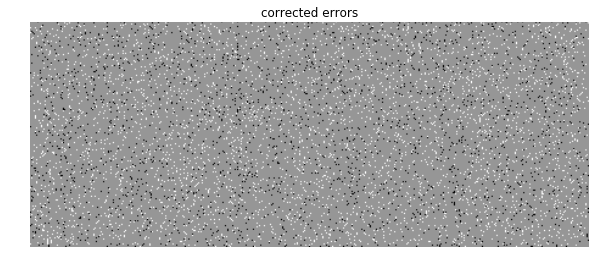

In [20]:
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(decoded-received_im,cmap="Greys_r",interpolation=None)
plt.title("corrected errors")
plt.show() 

## Shannon's noisy channel coding theorem

Probability and rate of repetition codes: for odd $N$:
\begin{equation}
R=\frac{1}{N}
\end{equation}
\begin{equation}
p_\mathrm{b}=\sum_{(N+1)/2}^{N} \binom{N}{n} \, f^n (1-f)^{N-n}
\end{equation}

In [21]:
R=np.array([1./N for N in xrange(1,62,2)])
p=np.array([np.sum(np.array([binom(N,n)*noise_level**n*(1-noise_level)**(N-n)
                             for n in xrange((N+1)/2,N)])) for N in xrange(1,62,2)])
p[0]=noise_level

binary entropy function:
\begin{equation}
H_2(x) \equiv x \log \frac{1}{x} + (1-x)\log \frac{1}{1-x}
\end{equation}
capacity of the noisy channel:
\begin{equation}
C(f) = 1 - H_2(f)
\end{equation}
Shannon limit:
\begin{equation}
R=\frac{C(f)}{1-H_2(f)}
\end{equation}

In [22]:
def H2(f):
    return f*np.log2(1./f) + (1-f)*np.log2(1./(1-f))
def capacity(noise_level):
    return 1.-H2(noise_level)
def shannon_limit(p,noise_level):
    return capacity(noise_level)/(1-H2(p))

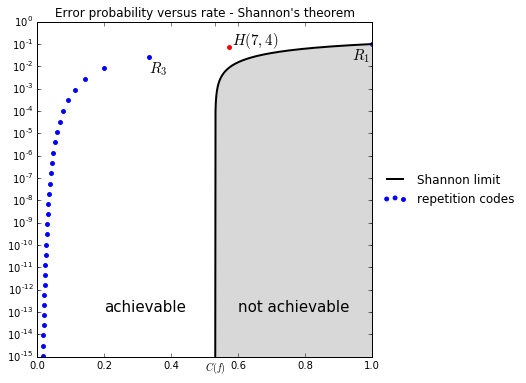

In [23]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,1)
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, capacity(noise_level)])
ax.set_xticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0", "$C(f)$"])
ax.set_yscale('log')
ax.scatter(R,p,s=60,marker='.',color='blue',label="repetition codes")
ax.scatter([4./7.],[7e-2],s=60,marker='.',color='red')
p_shannon=np.linspace(noise_level,1e-15,1000)
ax.plot(shannon_limit(p_shannon,noise_level),p_shannon,color='black',lw=2,label="Shannon limit")
ax.fill_betweenx(p_shannon,shannon_limit(p_shannon,noise_level),np.ones_like(p_shannon),
                 facecolor='grey',alpha=0.3, linewidth=0.)
ax.set_title("Error probability versus rate - Shannon's theorem")
ax.text(0.333, 5e-3, '$R_3$', fontsize=15)
ax.text(0.94, 2e-2, '$R_1$', fontsize=15)
ax.text(0.58, 1e-1, '$H(7,4)$', fontsize=15)
ax.text(0.2, 1e-13, 'achievable', fontsize=15)
ax.text(0.6, 1e-13, 'not achievable', fontsize=15)
plt.legend(frameon=False,loc='center left',bbox_to_anchor=(1, 0.5))
plt.show()